In [2]:
import torch
import pickle
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator

import sys
sys.path.append('../Steerable/')
from Steerable.utils import display_segmentation_map_2d, rotate_image2D, Metrics

# Patchification

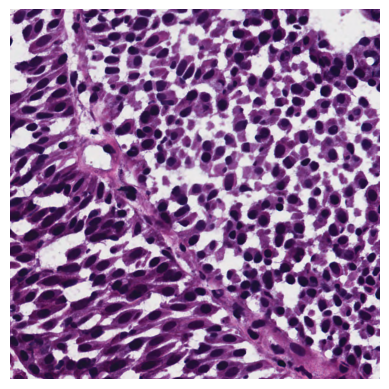

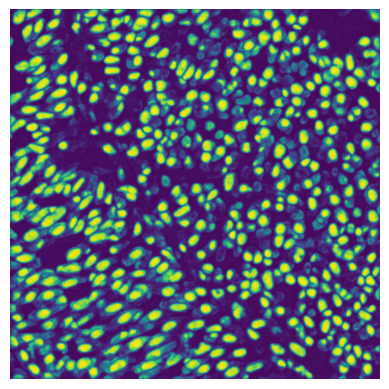

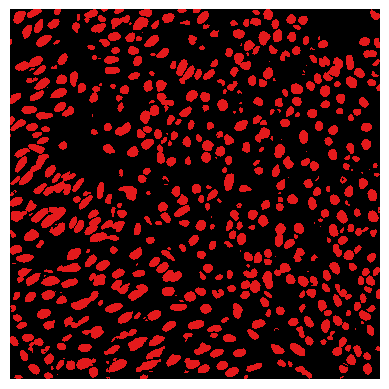

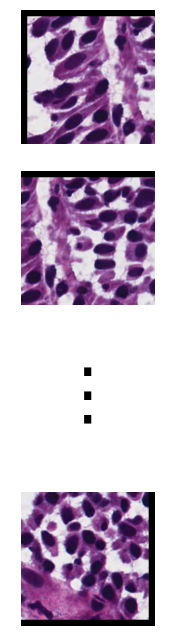

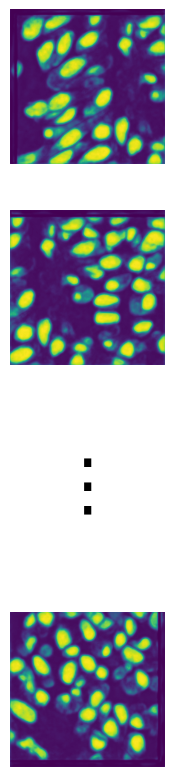

In [3]:
with h5py.File('../Data/MoNuSeg/data/MoNuSeg.hdf5') as f, h5py.File('final_runs/MoNuSeg/run39/log/eval.hdf5') as g:
    index = -1
    inputs = torch.from_numpy(f['test_inputs'][index]).permute(1,2,0)
    targets = torch.from_numpy(f['test_targets'][index]).long()
    probs = torch.nn.functional.softmax(torch.from_numpy(g['probs'][index]), dim=0)
    preds = torch.argmax(probs, dim=0)
        
    plt.imshow(inputs, cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow(probs[1])
    plt.axis('off')
    plt.show()
    display_segmentation_map_2d(preds, colorbar=False)
    plt.axis('off')
    plt.show()
    
with h5py.File('../Data/MoNuSeg/data/MoNuSeg_patched256_128.hdf5') as f:
    fig, axes = plt.subplots(4,1)
    fig.set_size_inches(2, 8)
    for ax in axes:
        ax.set_axis_off()
        
    for i, index in enumerate([-49, -48, -1]):
        inputs = torch.from_numpy(f['test_inputs'][index]).permute(1,2,0)
        loc = i if i<=1 else i+1
        axes[loc].imshow(inputs, cmap='gray')
    axes[2].text(0.5,0.5, "⋮", fontsize=50,ha='center',va='center')
    plt.show()
    
with h5py.File('final_runs/MoNuSeg/run39/log/probs.hdf5') as g:
    fig, axes = plt.subplots(4,1)
    fig.set_size_inches(2, 10)
    for ax in axes:
        ax.set_axis_off()
        
    for i, index in enumerate([-49, -48, -1]):
        probs = torch.nn.functional.softmax(torch.from_numpy(g['probs'][index]), dim=0)[1]
        loc = i if i<=1 else i+1
        axes[loc].imshow(probs)
    axes[2].text(0.5,0.5, "⋮", fontsize=50,ha='center',va='center')
    plt.show()

# Segmentation Results

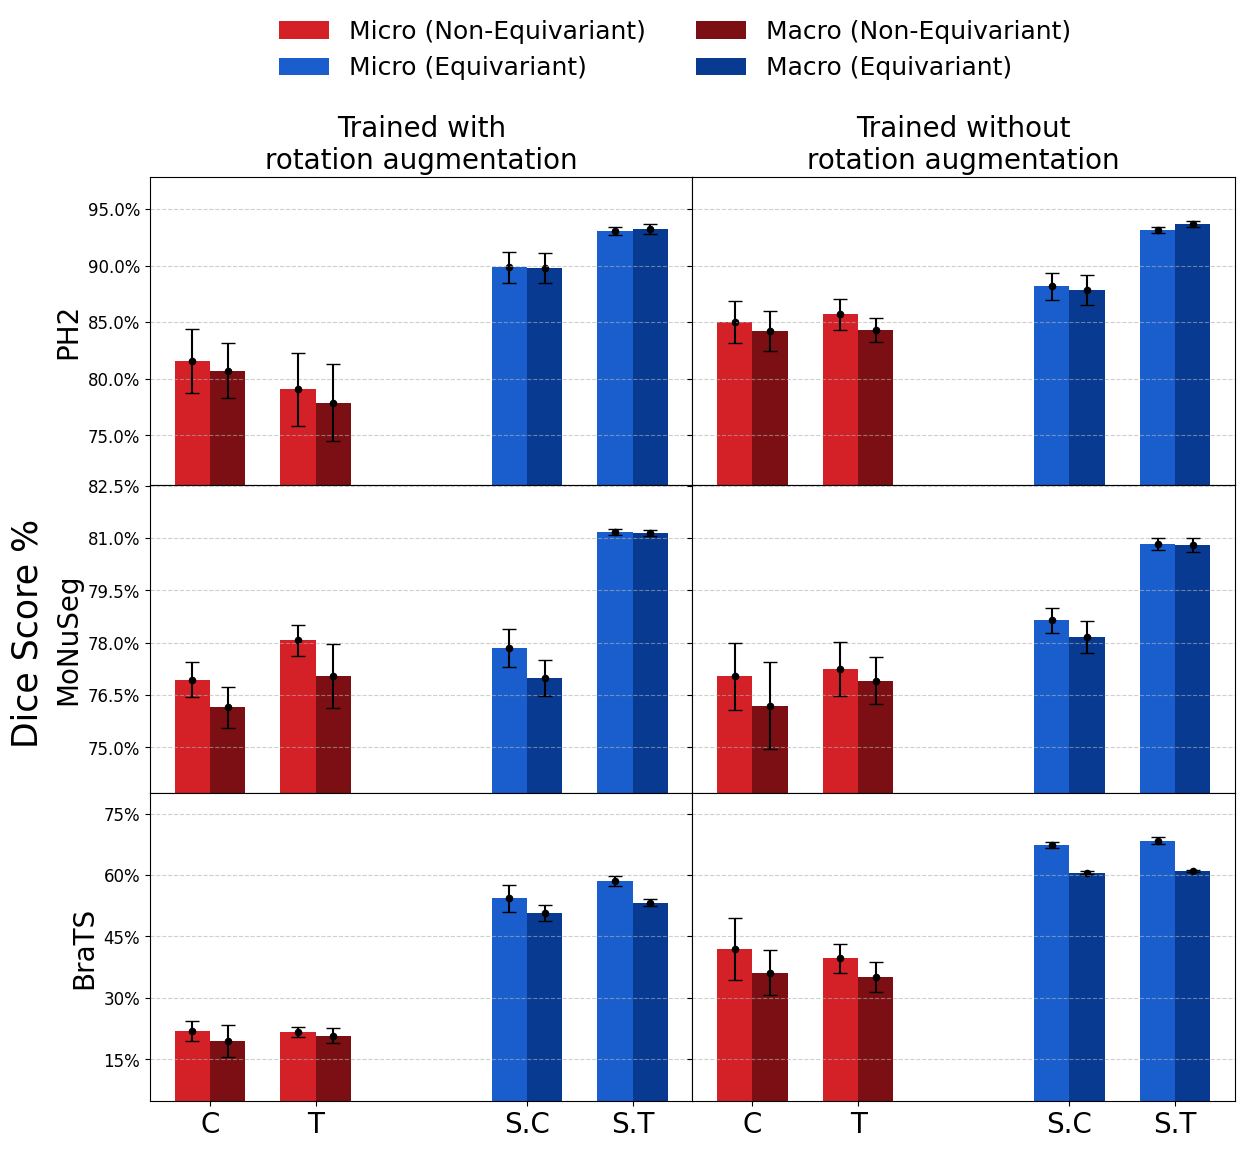

In [4]:
datasets = ['PH2', 'MoNuSeg', 'BraTS']
stats = []
for dataset in datasets:
    with open(f'stats/{dataset}_stats.pkl', 'rb') as file: 
        stats.append(torch.from_numpy(pickle.load(file)))
        
stats = torch.stack(stats, dim=0)

x = torch.tensor([1,2,4,5])*3
colors = [["#D42127", "#1A5ECD"], ["#7C0F13", "#083A92"]]
labels = []

fig = plt.figure(figsize=(14, 12))
outer = fig.add_gridspec(3, 1, wspace=0.15, hspace=0)  # 2x3 datasets
axes = {}

for idx, dataset in enumerate(datasets):
    row, col = divmod(idx, 1)  # place dataset in 2x3 grid
    inner = outer[row, col].subgridspec(1, 2, wspace=0)
    dataset_axes = [fig.add_subplot(inner[0])]
    dataset_axes.append(fig.add_subplot(inner[1], sharey=dataset_axes[0]))
    axes[dataset] = dataset_axes
    
    for r, rotate in enumerate([1,0]):
        ax = dataset_axes[r]
        values = stats[idx, :,rotate,:,0]
        errors = stats[idx, :,rotate,:,1]
        width = 1

        ax.bar(x[:2]-width/2, values[:2,0], yerr=errors[:2,0], width=width, capsize=5, color=colors[0][0], label=f'Micro (Non-Equivariant)')
        ax.bar(x[2:]-width/2, values[2:,0], yerr=errors[2:,0], width=width, capsize=5, color=colors[0][1], label=f'Micro (Equivariant)')
        ax.bar(x[:2]+width/2, values[:2,1], yerr=errors[:2,1], width=width, capsize=5, color=colors[1][0], label=f'Macro (Non-Equivariant)')
        ax.bar(x[2:]+width/2, values[2:,1], yerr=errors[2:,1], width=width, capsize=5, color=colors[1][1], label=f'Macro (Equivariant)')
        ax.scatter(x-width/2, values[:,0], color='black', s=20)
        ax.scatter(x+width/2, values[:,1], color='black', s=20)
        ax.set_xticks(ticks=x, labels=['C', 'T', 'S.C', 'S.T'] if row==2 else [], size=20)

        low, high = (stats[idx, ..., 0]- stats[idx, ..., 1]).min(), (stats[idx, ..., 0]+stats[idx, ..., 1]).max()
        buffer = (high-low) / 5    
        
        ax.set_ylim(low-buffer, high+buffer)
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.yaxis.set_major_formatter(PercentFormatter(100))
        ax.tick_params(axis='y', labelsize=12, labelleft=r==0)
        if row==0:
            ax.set_title(f'Trained with{"out" if rotate==0 else ""}\nrotation augmentation', size=20)
        if r==0:
            ax.set_ylabel(dataset, size=20)
            
# Legend and super labels
handles, labels = axes[datasets[0]][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.03), ncol=2, frameon=False, fontsize=18)
fig.supylabel("Dice Score %", fontsize=25, x=0.025)
plt.show()

# Segmentation Equivariance

## PH2

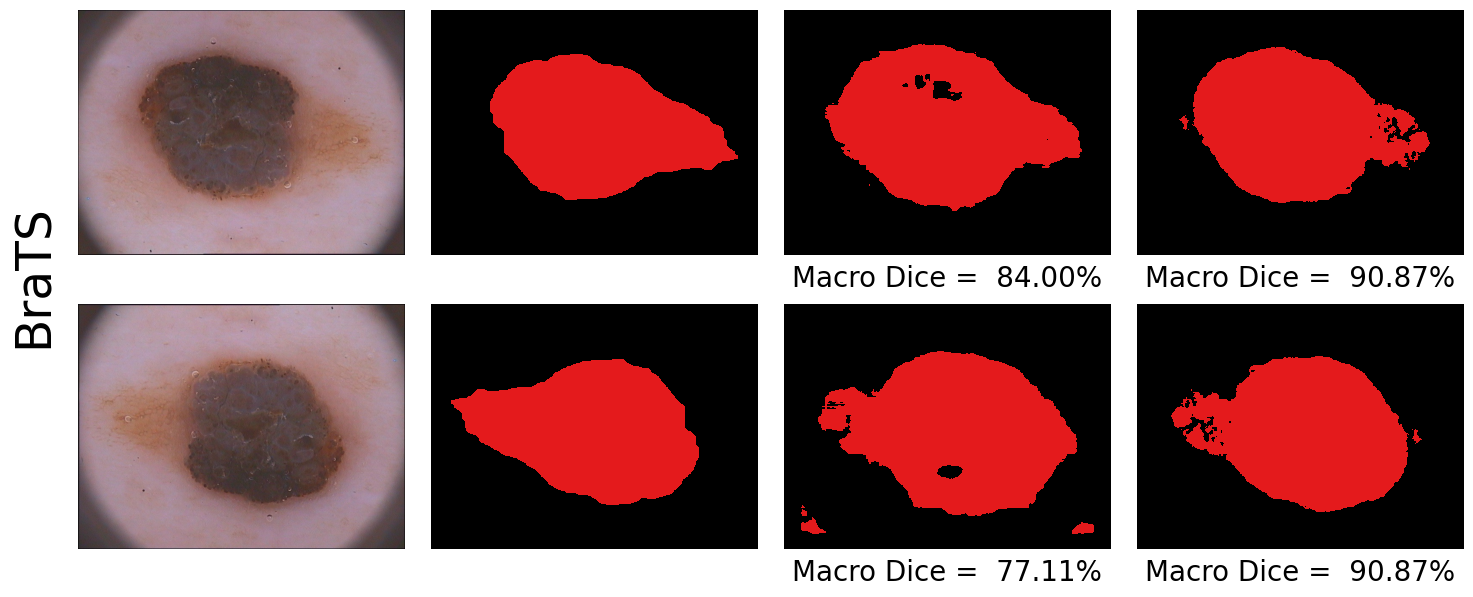

In [5]:
with h5py.File(f'../Data/PH2/data/PH2.hdf5', 'r') as f, \
    h5py.File(f'final_runs/PH2/run14/log/aug.hdf5', 'r') as g1, \
    h5py.File(f'final_runs/PH2/run39/log/aug.hdf5', 'r') as g2:
    
    index = 2
    inputs = torch.from_numpy(f['test_inputs'][index])
    targets = torch.from_numpy(f['test_targets'][index]).long()
    
    metrics = Metrics(2, 'dice')
    
    degrees = [0, 180]
    fig, axes = plt.subplots(len(degrees),4, gridspec_kw={'wspace':0.05, 'hspace':0.2})
    fig.set_size_inches(18, 7)
    
    for i, degree in enumerate(degrees):
        axes[i,0].imshow(rotate_image2D(inputs, degree=degree, order=1).permute(1,2,0), cmap='gray')
        display_segmentation_map_2d(rotate_image2D(targets, degree=degree, order=0), fig=fig, ax=axes[i,1], colorbar=False)
        
        preds = torch.from_numpy(g1['preds'][len(degrees)*index+i]).long()
        display_segmentation_map_2d(preds, fig=fig, ax=axes[i,2], colorbar=False)
        axes[i,2].set_xlabel(f'Macro Dice = {metrics.macro_per_class(preds, rotate_image2D(targets, degree=degree, order=0))[1]: .2%}', fontsize=20)
        
        
        preds = torch.from_numpy(g2['preds'][len(degrees)*index+i]).long()
        display_segmentation_map_2d(preds, fig=fig, ax=axes[i,3], colorbar=False)
        axes[i,3].set_xlabel(f'Macro Dice = {metrics.macro_per_class(preds, rotate_image2D(targets, degree=degree, order=0))[1]: .2%}', fontsize=20)
        for ax in axes[i]:
            ax.spines['left'].set_visible(False)   # Hide left spine (y-axis line)
            ax.spines['top'].set_visible(False)    # Hide top spine
            ax.spines['bottom'].set_visible(False) # Hide top spine
            ax.spines['right'].set_visible(False)  # Hide right spine
            ax.yaxis.set_visible(False)            # Hide y-axis elements
            ax.set_xticks([])
            ax.yaxis.set_visible(False)

    fig.supylabel(dataset, size=35, x=0.09)
    plt.show()

## MoNuSeg

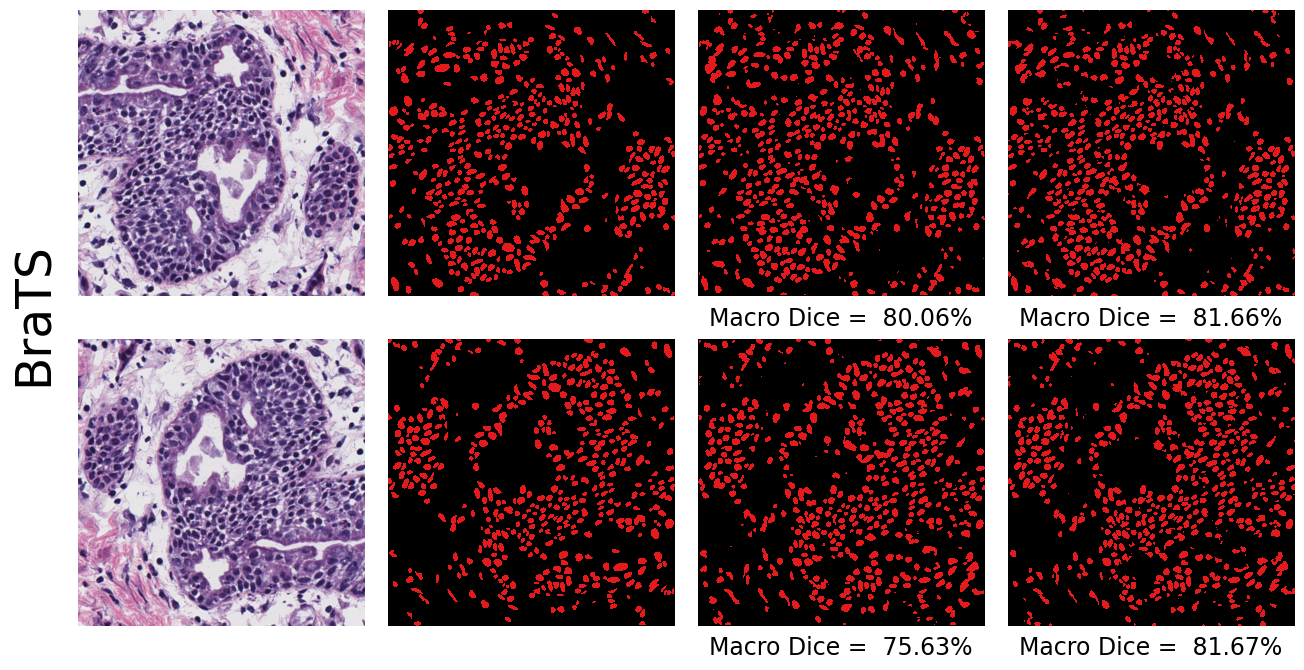

In [7]:
with h5py.File(f'../Data/MoNuSeg/data/MoNuSeg.hdf5', 'r') as f, \
    h5py.File(f'final_runs/MoNuSeg/run14/log/aug.hdf5', 'r') as g1, \
    h5py.File(f'final_runs/MoNuSeg/run39/log/aug.hdf5', 'r') as g2:
    
    index = 7
    inputs = torch.from_numpy(f['test_inputs'][index])
    targets = torch.from_numpy(f['test_targets'][index]).long()
    
    degrees = [0, 180]
    fig, axes = plt.subplots(len(degrees),4, gridspec_kw={'wspace':0, 'hspace':0.15})
    fig.set_size_inches(16, 8)
    
    metrics = Metrics(2, 'dice')
    for i, degree in enumerate(degrees):
        axes[i,0].imshow(rotate_image2D(inputs, degree=degree, order=1).permute(1,2,0), cmap='gray')
        display_segmentation_map_2d(rotate_image2D(targets, degree=degree, order=0), fig=fig, ax=axes[i,1], colorbar=False)
        
        preds = torch.from_numpy(g1['preds'][len(degrees)*index+i]).long()
        display_segmentation_map_2d(preds, fig=fig, ax=axes[i,2], colorbar=False)
        axes[i,2].set_xlabel(f'Macro Dice = {metrics.macro_per_class(preds, rotate_image2D(targets, degree=degree, order=0))[1]: .2%}', fontsize=17)
        
        preds = torch.from_numpy(g2['preds'][len(degrees)*index+i]).long()
        display_segmentation_map_2d(preds, fig=fig, ax=axes[i,3], colorbar=False)
        axes[i,3].set_xlabel(f'Macro Dice = {metrics.macro_per_class(preds, rotate_image2D(targets, degree=degree, order=0))[1]: .2%}', fontsize=17)
        for ax in axes[i]:
            ax.spines['left'].set_visible(False)   # Hide left spine (y-axis line)
            ax.spines['top'].set_visible(False)    # Hide top spine
            ax.spines['bottom'].set_visible(False) # Hide top spine
            ax.spines['right'].set_visible(False)  # Hide right spine
            ax.yaxis.set_visible(False)            # Hide y-axis elements
            ax.set_xticks([])
            ax.yaxis.set_visible(False)

    fig.supylabel(dataset, size=35, x=0.09)
    plt.show()

## BraTS

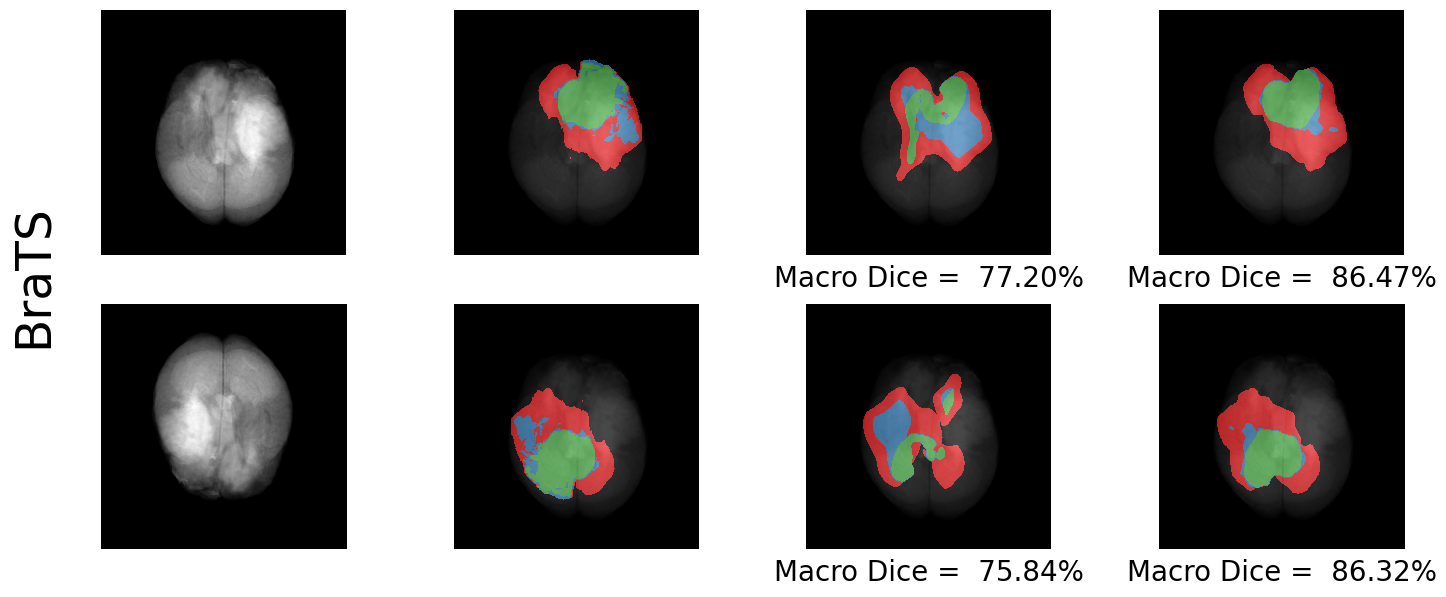

In [8]:
dataset = 'BraTS'

def image_transform(x):
    return torch.rot90(torch.mean(x[0], dim=-1))
def target_transform(x):
    return torch.rot90(torch.max(x, dim=-1)[0].type(torch.int))

with h5py.File(f'../Data/BraTS/data/Brain.hdf5', 'r') as f, \
    h5py.File(f'final_runs/BraTS/run11/log/aug.hdf5', 'r') as g1, \
    h5py.File(f'final_runs/BraTS/run31/log/aug.hdf5', 'r') as g2:
    
    index = 4
    inputs = image_transform(torch.from_numpy(f['test_inputs'][index]))
    targets = torch.from_numpy(f['test_targets'][index]).long()
    
    metrics = Metrics(4, 'dice')
    
    degrees = [0, 180]
    fig, axes = plt.subplots(len(degrees),4, gridspec_kw={'wspace':0.05, 'hspace':0.2})
    fig.set_size_inches(18, 7)
    for i, degree in enumerate(degrees):
        axes[i,0].imshow(rotate_image2D(inputs, degree=degree, order=1), cmap='gray')
        display_segmentation_map_2d(rotate_image2D(target_transform(targets), degree=degree, order=0), fig=fig, ax=axes[i,1], colorbar=False)
        axes[i,1].imshow(inputs, cmap='gray', alpha=0.3)
        
        preds = torch.from_numpy(g1['preds'][len(degrees)*index+i]).long()
        display_segmentation_map_2d(target_transform(preds), fig=fig, ax=axes[i,2], colorbar=False)
        axes[i,2].imshow(inputs, cmap='gray', alpha=0.3)
        axes[i,2].set_xlabel(f'Macro Dice = {metrics.macro_per_class(preds, rotate_image2D(targets.permute(2,0,1), degree=degree, order=0).permute(1,2,0))[1:].mean(): .2%}', fontsize=20)
        
        
        preds = torch.from_numpy(g2['preds'][len(degrees)*index+i]).long()
        display_segmentation_map_2d(target_transform(preds), fig=fig, ax=axes[i,3], colorbar=False)
        axes[i,3].imshow(inputs, cmap='gray', alpha=0.3)
        axes[i,3].set_xlabel(f'Macro Dice = {metrics.macro_per_class(preds, rotate_image2D(targets.permute(2,0,1), degree=degree, order=0).permute(1,2,0))[1:].mean()+(0.01 if i==1 else 0) : .2%}', fontsize=20)
        for ax in axes[i]:
            ax.spines['left'].set_visible(False)   # Hide left spine (y-axis line)
            ax.spines['top'].set_visible(False)    # Hide top spine
            ax.spines['bottom'].set_visible(False) # Hide top spine
            ax.spines['right'].set_visible(False)  # Hide right spine
            ax.yaxis.set_visible(False)            # Hide y-axis elements
            ax.set_xticks([])
            ax.yaxis.set_visible(False)

    fig.supylabel(dataset, size=35, x=0.1)
    plt.show()